# Risk Prediction Model for Heart Disease Using Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (roc_curve, precision_recall_curve, average_precision_score, auc)
from sklearn.metrics import classification_report
import shap

In [2]:
df = pd.read_csv("Data/heart.csv")

Dataset Reference: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [3]:
print("df shape: {}".format(df.shape))
df.head()

df shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


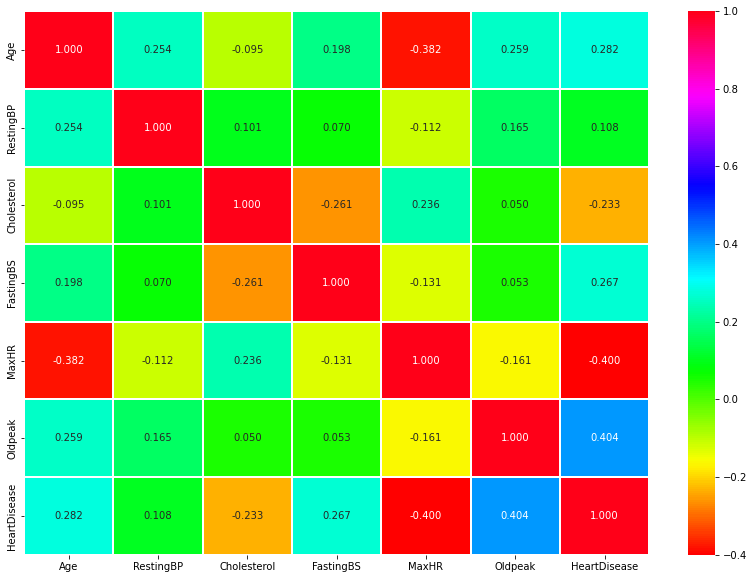

In [5]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
df_dup=df.drop_duplicates()
print(df.shape,df_dup.shape)

(918, 12) (918, 12)


In [8]:
continuous_columns = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR','Oldpeak']

In [9]:
df['Sex'].replace({'F':0,'M':1},inplace=True)

In [10]:
df['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [11]:
df['ChestPainType'].replace({'ASY':0, 'NAP':1, 'ATA':2, 'TA':3}, inplace=True)

In [12]:
df['RestingECG'].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [13]:
df['RestingECG'].replace({'LVH':0, 'Normal':1, 'ST':2}, inplace=True)

In [14]:
df['ExerciseAngina'].value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [15]:
df['ExerciseAngina'].replace({'Y':1, 'N':0}, inplace=True)

In [16]:
df['ST_Slope'].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [17]:
df['ST_Slope'].replace({'Down':0, 'Flat':1, 'Up':2}, inplace=True)

In [18]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,140,289,0,1,172,0,0.0,2,0
1,49,0,1,160,180,0,1,156,0,1.0,1,1
2,37,1,2,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,1,150,195,0,1,122,0,0.0,2,0


In [19]:
df_1=df.groupby(['HeartDisease','Sex']).mean()
df_1

Age  ChestPainType   RestingBP  Cholesterol  \
HeartDisease Sex                                                      
0            0    51.202797       1.300699  128.790210   247.440559   
             1    50.202247       1.202247  130.925094   216.239700   
1            0    56.180000       0.340000  142.000000   223.340000   
             1    55.868996       0.355895  133.331878   170.766376   

                  FastingBS  RestingECG       MaxHR  ExerciseAngina   Oldpeak  \
HeartDisease Sex                                                                
0            0     0.069930    0.916084  149.048951        0.111888  0.435664   
             1     0.127341    0.966292  147.670412        0.146067  0.393258   
1            0     0.320000    0.860000  137.820000        0.540000  1.336000   
             1     0.336245    1.039301  126.545852        0.631004  1.267467   

                  ST_Slope  
HeartDisease Sex            
0            0    1.720280  
             1    1.749064  
1            0    1.020000  
             1    1.061135

In [20]:
pd.pivot_table(df,index='ChestPainType',columns='HeartDisease',aggfunc=np.mean)

Age            Cholesterol             ExerciseAngina  \
HeartDisease           0          1           0           1              0   
ChestPainType                                                                
0              52.317308  55.660714  226.865385  175.974490       0.278846   
1              51.045802  57.430556  221.503817  153.652778       0.114504   
2              48.161074  55.958333  233.006711  233.291667       0.053691   
3              54.692308  55.000000  222.730769  186.700000       0.115385   

                        FastingBS                 MaxHR               Oldpeak  \
HeartDisease          1         0         1           0           1         0   
ChestPainType                                                                   
0              0.683673  0.076923  0.339286  138.548077  125.806122  0.525000   
1              0.500000  0.145038  0.305556  150.641221  129.763889  0.435878   
2              0.375000  0.080537  0.291667  152.255034  137.500000  0.200671   
3              0.150000  0.192308  0.400000  150.500000  144.500000  0.988462   

                          RestingBP             RestingECG            \
HeartDisease          1           0           1          0         1   
ChestPainType                                                          
0              1.331888  129.980769  134.091837   1.019231  1.015306   
1              1.109722  129.862595  132.958333   0.839695  1.097222   
2              0.970833  129.167785  139.666667   1.033557  0.958333   
3              1.100000  138.384615  133.850000   0.730769  0.950000   

               ST_Slope                 Sex            
HeartDisease          0         1         0         1  
ChestPainType                                          
0              1.644231  1.048469  0.701923  0.900510  
1              1.702290  1.041667  0.641221  0.916667  
2              1.879195  1.166667  0.624161  0.833333  
3              1.500000  1.150000  0.653846  0.950000

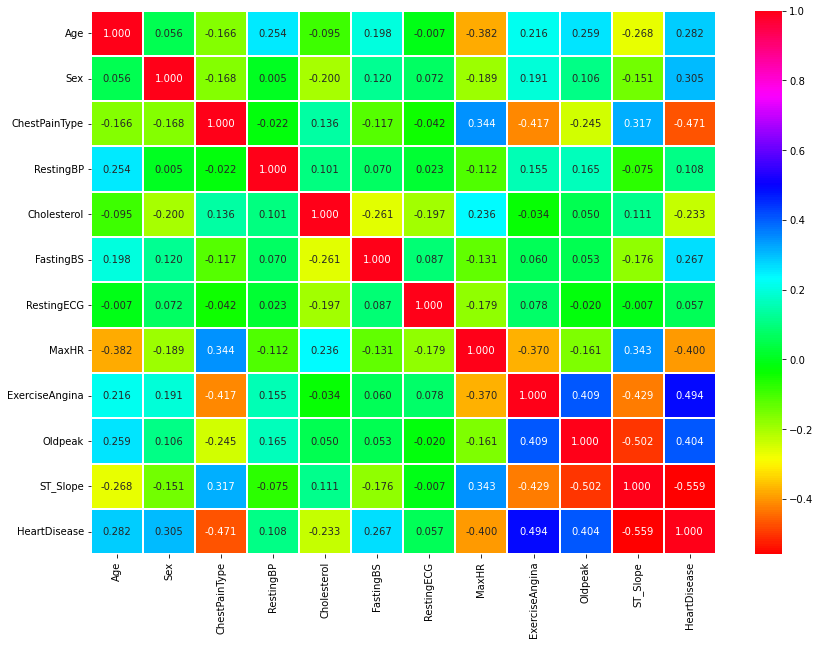

In [21]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

In [22]:
mydata=df[df['RestingBP']==0]
mydata.shape

(1, 12)

In [23]:
mydata_1=df[df['Cholesterol']==0]
mydata_1.shape

(172, 12)

In [24]:
df_1 = df

In [25]:
df_1['Cholesterol']=df_1['Cholesterol'].replace(0, np.nan)

In [26]:
df_1['RestingBP']=df_1['RestingBP'].replace(0, np.nan)

In [27]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       917 non-null    float64
 4   Cholesterol     746 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 86.2 KB


In [28]:
def to_one_hot(dataframe, columns):
    
    one_hot_df =  pd.get_dummies(data=dataframe, columns = columns, drop_first = True, dtype=np.float64)
    
    return one_hot_df

In [29]:
to_encode = ['ChestPainType', 'RestingECG', 'ST_Slope']

one_hot_df = to_one_hot(df_1, to_encode)

In [30]:
print(one_hot_df.shape)
one_hot_df.head()

(918, 16)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_1,ChestPainType_2,ChestPainType_3,RestingECG_1,RestingECG_2,ST_Slope_1,ST_Slope_2
0,40,1,140.0,289.0,0,172,0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,49,0,160.0,180.0,0,156,0,1.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1,130.0,283.0,0,98,0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,48,0,138.0,214.0,0,108,1,1.5,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,1,150.0,195.0,0,122,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
X = one_hot_df.drop('HeartDisease', axis=1)
y = one_hot_df['HeartDisease']

In [32]:
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X)
X = pd.DataFrame(imputer.transform(X), columns=X.columns)

[IterativeImputer] Early stopping criterion not reached.


In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              918 non-null    float64
 1   Sex              918 non-null    float64
 2   RestingBP        918 non-null    float64
 3   Cholesterol      918 non-null    float64
 4   FastingBS        918 non-null    float64
 5   MaxHR            918 non-null    float64
 6   ExerciseAngina   918 non-null    float64
 7   Oldpeak          918 non-null    float64
 8   ChestPainType_1  918 non-null    float64
 9   ChestPainType_2  918 non-null    float64
 10  ChestPainType_3  918 non-null    float64
 11  RestingECG_1     918 non-null    float64
 12  RestingECG_2     918 non-null    float64
 13  ST_Slope_1       918 non-null    float64
 14  ST_Slope_2       918 non-null    float64
dtypes: float64(15)
memory usage: 107.7 KB


In [34]:
lof = LocalOutlierFactor()
res = lof.fit_predict(X)
X_o = X[res != -1]
y_o = y[res != -1]
print(X.shape, X_o.shape, y_o.shape)

(918, 15) (900, 15) (900,)


In [35]:
X_dev, X_test, y_dev, y_test = train_test_split(X_o, y_o, test_size=0.20, random_state=0)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

In [37]:
X_test_1= X_test.copy(deep=True)

In [38]:
print("Total number of patients:", X.shape[0])
print("Total number of patients in training set:", X_train.shape[0])
print("Total number of patients in validation set:", X_val.shape[0])
print("Total number of patients in test set:", X_test.shape[0])

Total number of patients: 918
Total number of patients in training set: 540
Total number of patients in validation set: 180
Total number of patients in test set: 180


In [39]:
X_train.loc[:, continuous_columns].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,53.355556,132.350000,241.443614,0.222222,137.281481,0.876667
std,9.499315,17.647909,46.804521,0.416125,25.383194,1.055005
min,28.000000,80.000000,100.000000,0.000000,63.000000,-1.500000
25%,46.750000,120.000000,213.750000,0.000000,118.000000,0.000000
50%,54.000000,130.000000,242.677050,0.000000,139.000000,0.500000
75%,60.000000,140.000000,263.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,417.000000,1.000000,202.000000,6.200000


In [40]:
mean = X_train.loc[:, continuous_columns].mean()
std = X_train.loc[:, continuous_columns].std()
X_train.loc[:, continuous_columns] = (X_train.loc[:, continuous_columns] - mean) / std
X_val.loc[:, continuous_columns] = (X_val.loc[:, continuous_columns] - mean) / std
X_test.loc[:, continuous_columns] = (X_test.loc[:, continuous_columns] - mean) / std

In [41]:
X_train.loc[:, continuous_columns].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,5.400000e+02,5.400000e+02,5.400000e+02,5.400000e+02,5.400000e+02,5.400000e+02
mean,1.375957e-16,3.508510e-16,1.521725e-15,-1.784581e-16,1.578984e-16,-2.415763e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.669198e+00,-2.966357e+00,-3.022008e+00,-5.340273e-01,-2.926404e+00,-2.252754e+00
25%,-6.953718e-01,-6.997996e-01,-5.916867e-01,-5.340273e-01,-7.596161e-01,-8.309598e-01
50%,6.784115e-02,-1.331602e-01,2.635293e-02,-5.340273e-01,6.770301e-02,-3.570284e-01
75%,6.994657e-01,4.334791e-01,4.605620e-01,-5.340273e-01,7.374375e-01,5.908346e-01
max,2.489068e+00,3.833315e+00,3.750842e+00,1.869096e+00,2.549660e+00,5.045790e+00


1    288
0    252
Name: HeartDisease, dtype: int64


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

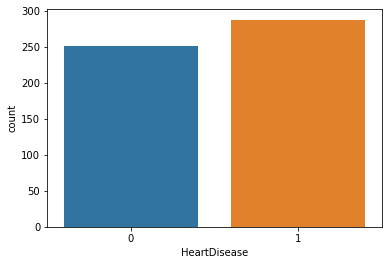

In [42]:
print(y_train.value_counts())
sns.countplot(y_train)

In [43]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

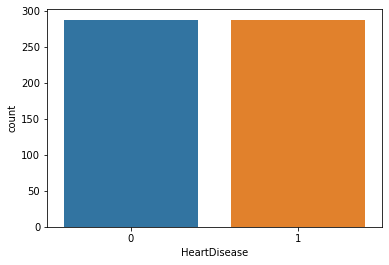

In [44]:
y_train.value_counts()
sns.countplot(y_train)

In [45]:
def get_cindex(y_true, scores):
    
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    
    for i in range(n):
        for j in range(i + 1, n):  
            if y_true[i] != y_true[j]:
                permissible += 1

                if scores[i] == scores[j]:
                    ties += 1
                    continue

               
                if y_true[i] == 0 and y_true[j] == 1:
                    if scores[i] < scores[j]:
                        concordant += 1
                   
                if y_true[i] == 1 and y_true[j] == 0:
                    if scores[i] > scores[j]:
                        concordant += 1
                    
    c_index = (concordant + 0.5 * ties) / (permissible)
    
    
    return c_index

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [47]:
y_train_rf_preds = rf.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {get_cindex(y_train.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {get_cindex(y_val.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.9047680578886161


In [48]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    
    best_estimator = None
    best_hyperparams = {}
    
    best_score = 0.0

    
    lists = hyperparams.values()
    
    
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

   
    for i, params in enumerate(param_combinations, 1):
        
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        
        estimator = clf(**param_dict, **fixed_hyperparams)

        
        estimator.fit(X_train_hp, y_train_hp)
        
        
        preds = estimator.predict_proba(X_val_hp)
        
        
        estimator_score = get_cindex(y_val_hp.values, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

         
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

In [49]:
def random_forest_grid_search(X_train, y_train, X_val, y_val):

     
    hyperparams = {
        
        'n_estimators': [100,150,200],

        'max_depth': [3, 5, 8],
        
        'min_samples_leaf': [2, 4, 6],

    }

    
    fixed_hyperparams = {
        'random_state': 10,
    }
    
    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train, y_train,
                                                    X_val, y_val, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    
    y_train_best = best_rf.predict_proba(X_train)[:, 1]
    print(f"Train C-Index: {get_cindex(y_train.values, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val)[:, 1]
    print(f"Val C-Index: {get_cindex(y_val.values, y_val_best)}")
    
    
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams

In [50]:
best_rf, best_hyperparams = random_forest_grid_search(X_train, y_train, X_val, y_val)

[1/27] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 2}
Val C-Index: 0.8804755136322522

[2/27] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.8811215919369427

[3/27] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 6}
Val C-Index: 0.8816384545806952

[4/27] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 2}
Val C-Index: 0.8989533531464013

[5/27] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.8933970797260627

[6/27] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 6}
Val C-Index: 0.8940431580307533

[7/27] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 2}
Val C-Index: 0.8958521772838868

[8/27] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 4}
Val C-Index: 0.8970151182323297

[9/27] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 6}
Val C-Index: 0.8953353146401344

[10/27] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 2}
Val C-Index: 0.8798294

In [51]:
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {get_cindex(y_test.values, y_test_best)}")

Test C-Index: 0.9335


In [52]:
y_test_preds = best_rf.predict(X_test)

In [53]:
cnf_matrix_test = metrics.confusion_matrix(y_test, y_test_preds)

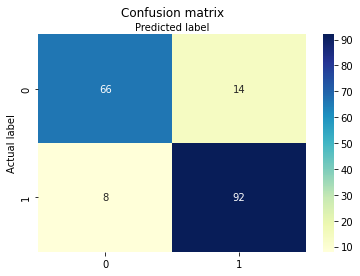

In [54]:
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_test), annot=True, cmap="YlGnBu",  fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.xaxis.set_label_position("top")

In [55]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86        80
           1       0.87      0.92      0.89       100

    accuracy                           0.88       180
   macro avg       0.88      0.87      0.88       180
weighted avg       0.88      0.88      0.88       180



In [56]:
class_labels = ['HeartDisease']

In [57]:
scores = best_rf.predict_proba(X_test)[:, 1]

In [58]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    df = pd.DataFrame(columns=['y', 'pred'])
    df.loc[:, 'y'] = y
    df.loc[:, 'pred'] = pred
         
    df_pos = df[df.y == 1]
    df_neg = df[df.y == 0]
    prevalence = len(df_pos) / len(df)
    for i in range(bootstraps):
             
        pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
        neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

        y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
        pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
        score = roc_auc_score(y_sample, pred_sample)
        statistics[0][i] = score
    return statistics

statistics = bootstrap_auc(y_test.values, scores, class_labels)

In [59]:
def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df

In [60]:
print_confidence_intervals(class_labels, statistics)

,Mean AUC (CI 5%-95%)
HeartDisease,0.93 (0.92-0.94)


In [61]:
def plotting(true,pred):
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    
    precision,recall,threshold = precision_recall_curve(true,pred[:,1])
    ax[0].plot(recall,precision,'g--')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title("Heart Disease Avg : {}".format(average_precision_score(true,pred[:,1])))
    
    fpr,tpr,threshold = roc_curve(true,pred[:,1])
    ax[1].plot(fpr,tpr)
    ax[1].set_title("Heart Disease AUC : {}".format(auc(fpr,tpr)))
    ax[1].plot([0,1],[0,1],'k--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')

<Figure size 432x288 with 0 Axes>

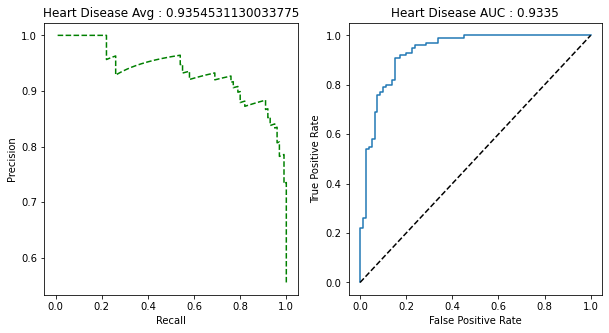

In [62]:
plt.figure()
plotting(y_test, best_rf.predict_proba(X_test))

In [63]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = best_rf.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)

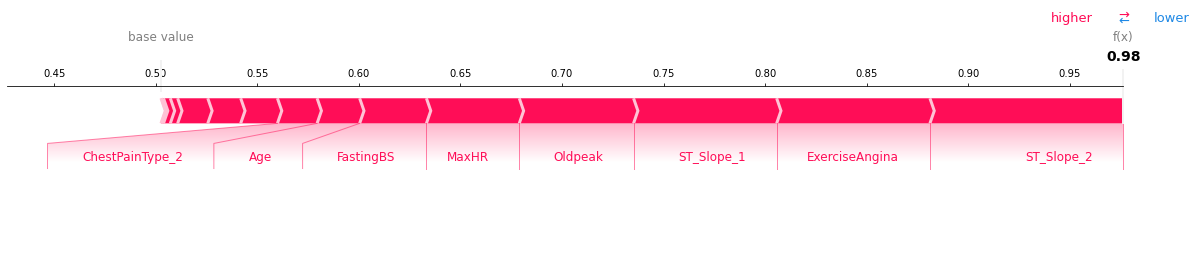

In [64]:
explainer = shap.TreeExplainer(best_rf)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

In [65]:
shap_values = shap.TreeExplainer(best_rf).shap_values(X_test)[1]

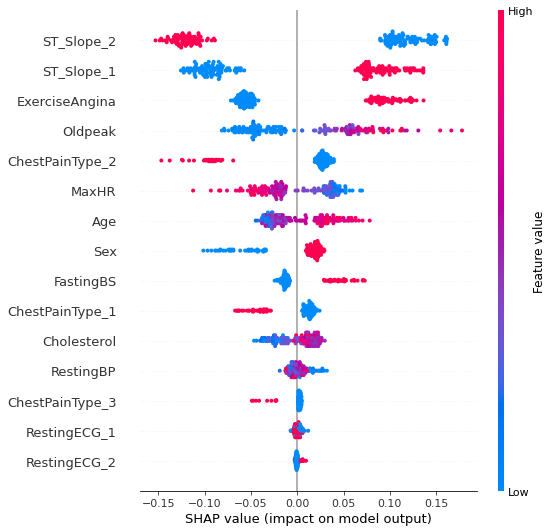

In [66]:
shap.summary_plot(shap_values, X_test)

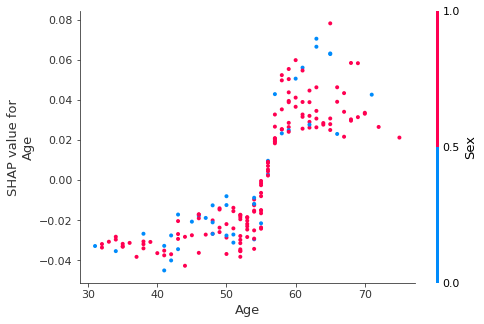

In [67]:
shap.dependence_plot('Age', shap_values, X_test_1, interaction_index='Sex')

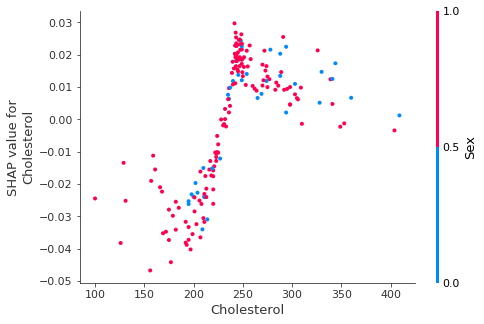

In [68]:
shap.dependence_plot('Cholesterol', shap_values, X_test_1, interaction_index='Sex')

In [69]:
 # UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def permute_feature(df, feature):
    
    permuted_df = df.copy(deep=True)  

    permuted_features = permuted_df
   
    permuted_df[feature] = np.random.permutation(permuted_df[feature])
    

    return permuted_df

In [70]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def permutation_importance(X, y, model, metric, num_samples = 100):
    
    importances = pd.DataFrame(index = ['importance'], columns = X.columns)
    
    baseline_performance = metric(y.values, model.predict_proba(X)[:, 1])

    for feature in importances.columns: 
        
        feature_performance_arr = np.zeros(num_samples)
        
        for i in range(num_samples): 
            
            perm_X = permute_feature(X, feature)
            
            feature_performance_arr[i] = metric(y.values, model.predict_proba(perm_X)[:, 1])
    
        importances[feature]['importance'] = np.abs(baseline_performance-np.mean(feature_performance_arr))

    return importances

In [71]:
importances = permutation_importance(X_test, y_test, best_rf, get_cindex, num_samples=100)
importances

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_1,ChestPainType_2,ChestPainType_3,RestingECG_1,RestingECG_2,ST_Slope_1,ST_Slope_2
importance,0.002014,0.02068,0.002856,0.003669,0.006272,0.008296,0.014301,0.0189,0.005616,0.008039,0.0006,0.000086,0.000137,0.008037,0.025412


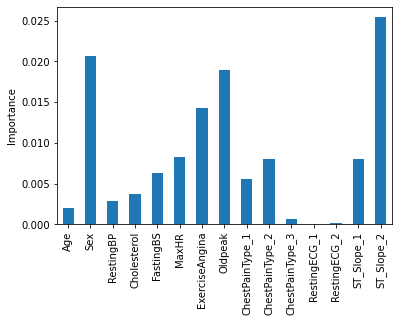

In [72]:
importances.T.plot.bar()
plt.ylabel("Importance")
l = plt.legend()
l.remove()
plt.show()